# DTSA-5510:  Final Project
### June 20, 2022


## An Unsupervised Machine Learning Approach for Movie Recommendations Based on User Submitted Reviews
### Introduction

This is the Final Project for DTSA-5510, Unsupervised Algorithms in Machine Learning.  This project applies unsupervised learning algorithms to movie data in an attempt to generate a movie recommendation system based _solely_ on the reviews submitted by users.  
  
All other movie recommendation systems I'd read about were essentially genre based, where films are recommended based on how similar the recommended films genres are to the film in question. Mine is an entirely different approach in that a film's genre(s) and its ratings are not given to the unsupervised algorithm. Instead, only the text of user submitted reviews are utilized in training the model.

This approach had several challenges, the first of which was just finding the data. The movies.csv file as well and the train and test csv files are the same as ones used during Week 3 of the course. Finding user reviews proved more difficult, but I found a large set on [Kaggle](https://www.kaggle.com/),  IMDB_reviews.json, which is part of a larger dataset, [IMDB Spoiler Dataset](https://www.kaggle.com/datasets/rmisra/imdb-spoiler-dataset?select=IMDB_reviews.json).

However, I still needed a way to link the files from the course to the user reviews. This I was able to get using the links.csv file from the [MovieLens 25M Dataset](https://grouplens.org/datasets/movielens/).
  
All of these files, with the exception of the IMDB Reviews file, as well as the Jupyter notebook used to this create report, can be found at and cloned from https://github.com/clayv/DTSA-5510_Final_Project. The IMDB Reviews file is too large, even if compressed, to be uploaded to GitHub and must be downloaded separately from the [IMDB Spoiler Dataset](https://www.kaggle.com/datasets/rmisra/imdb-spoiler-dataset?select=IMDB_reviews.json) on [Kaggle](https://www.kaggle.com/).

Finally to those reviewing this... please accept my apologies in advance. When I began this experiment I did not realize how many pages this project would wind up being.

**References:**  
Beysolow, T. (2018). _Applied Natural Language Processing with Python_. Apress  
Nixon, A. (2020, August 28). Building a movie content based recommender using tf-idf. Towards Data Science. https://towardsdatascience.com/content-based-recommender-systems-28a1dbd858f5

In [80]:
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
from scipy.spatial import distance
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
import sklearn.metrics as metrics

#Change to None if results other than thos documented are desired
randomState = 42

### Step 0: Load the data

In [2]:
pd.set_option("display.max_colwidth", None)

dfReviews = pd.read_json("./data/IMDB_reviews.json.zip", orient = "records", lines = True, compression="zip")
dfLinks = pd.read_csv("./data/links.csv")
dfMovies = pd.read_csv("./data/movies.csv")
dfTrain = pd.read_csv("./data/train.csv")
dfTest = pd.read_csv("./data/test.csv")


Initial examination of the data revealed no null data in any of the fields of interest for this project

In [3]:
def printDfInfo(df, name):
    print("{} dataframe:".format(name))
    df.info()
    #print(df.head())
    print()
    
printDfInfo(dfReviews, "Reviews")
printDfInfo(dfLinks, "Links")
printDfInfo(dfMovies, "Movies")
printDfInfo(dfTrain, "Training")
printDfInfo(dfTest, "Test")


Reviews dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573913 entries, 0 to 573912
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   review_date     573913 non-null  object
 1   movie_id        573913 non-null  object
 2   user_id         573913 non-null  object
 3   is_spoiler      573913 non-null  bool  
 4   review_text     573913 non-null  object
 5   rating          573913 non-null  int64 
 6   review_summary  573913 non-null  object
dtypes: bool(1), int64(1), object(5)
memory usage: 26.8+ MB

Links dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int64  
 1   imdbId   62423 non-null  int64  
 2   tmdbId   62316 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB

Movies dataframe:
<class 'pandas.core.f

### Step 1:  Data Wrangling
Although the links.csv file does provide for linking between the Movies and Reviews files, the format of the each of the files uses is different.  The imdbId and movie_id, from Links and Reviews respectively, hold the mapping field but Links uses a numeric field, int64, and Reviews an object. Further complicating this is the Reviews file stores the field with a prepended with a "tt" and sometimes a leading 0 as well

In [4]:
dfLinks.head(2)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0


In [5]:
dfReviews.head(2)


review_date   movie_id    user_id  is_spoiler  \
0  10 February 2006  tt0111161  ur1898687        True   
1  6 September 2000  tt0111161  ur0842118        True   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

The following cell strips the leading "tt" and the conversion to an int64 will drop a leading 0 if present.  This modified field is then inserted into the Reviews dataframe as an int64 named "imdbId" to match the field name in Links

In [6]:
# Add imdbId column to dfReviews
dfReviews.insert(1, "imdbId", np.int64(dfReviews.movie_id.str.strip('tt')), True)
dfReviews.head(2)


review_date  imdbId   movie_id    user_id  is_spoiler  \
0  10 February 2006  111161  tt0111161  ur1898687        True   
1  6 September 2000  111161  tt0111161  ur0842118        True   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

Now that the Movies and Reviews dataframes can be linked with a uniform field via the Links dataframe, many of the fields in both Reviews and Movies can be dropped. Note that the rating field from Reviews is one of the columns being dropped so it will be impossible for ratings to influence the machine learning model.

In [7]:
# Drop unneeded columns from Reviews
dfReviews.drop(['review_date', 'movie_id', 'user_id', 'is_spoiler', 'rating', 'review_summary'], axis = 1, inplace = True)
dfReviews.head(2)

imdbId  \
0  111161   
1  111161   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [8]:
# Drop unneeded columns from Movies
dfMovies.drop(dfMovies.iloc[:, 2:21], axis = 1, inplace = True)
dfMovies.head(2)


,mID,title
0,1,Toy Story
1,2,Jumanji


Next we'll aggregate all the reviews for a given movie into a single string and then add that string into a new field in the Movies dataframe named "all_reviews".  
  
Once all the reviews have been added, any movies without reviews will be dropped from Movies.

In [9]:
def collectReviews():
    dfMovies['all_reviews'] = ""
    for index in range(len(dfMovies)):
        allReviews = ""
        for imdbId in dfLinks[dfLinks.movieId == dfMovies.iloc[index, 0]].imdbId:
            for review in dfReviews[dfReviews.imdbId == imdbId].review_text:#.to_string(index = False):
                allReviews += (review + " ")
            if len(allReviews) > 10:
                dfMovies.iloc[index, 2] = allReviews
            else:
                dfMovies.iloc[index, 2] = np.nan

collectReviews()
dfMovies.dropna(axis = 0, how = 'any', subset = ["all_reviews"], inplace = True)
dfMovies.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 595 entries, 0 to 3879
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   mID          595 non-null    int64 
 1   title        595 non-null    object
 2   all_reviews  595 non-null    object
dtypes: int64(1), object(2)
memory usage: 18.6+ KB


Of note is that originally Movies had 3,883 records but after dropping the films without reviews there are only 595 movies left.  This represents only 15% of the movies we originally had, but should still be sufficient to test how well user submitted reviews enable movie recommendations.

### Step 2: Exploratory Data Analysis, Visualizations, and Data Cleaning
With only 15% of the movies remaining, a first check should be to see how many users a have reviewed films that remain. The reviews from both the the training and test datasets will be pruned to only those that remains in the Movies dataframe. Additionally, the two dataframes can be concatenated for ease of use as we are not training the model on any records in the train or test datasets.

In [10]:
dfTrain = dfTrain[dfTrain['mID'].isin(dfMovies['mID'])]
dfTest = dfTest[dfTest['mID'].isin(dfMovies['mID'])]
dfAllRatings = pd.concat([dfTrain, dfTest])
display(dfAllRatings)


,uID,mID,rating
0,744,1210,5
1,3040,1584,4
2,1451,1293,5
3,5455,3176,2
5,1465,1210,5
...,...,...,...
300051,3464,2424,4
300052,4271,1263,4
300053,1837,97,4
300057,5950,1584,3


After removing user rating for movies no longer in the Movies dataframe, there are still 430,349 ratings that can test the recommendation engine.  Having a large number is very important, as not all reviewers will have reviewed enough movies to check their ratings against the recommendation engine.  
  
The next cell creates plots of the distribution of each user's average rating, the distribution of number of reviews each user has contributed, and the count of each rating.

Number of reviews with a rating of 5: 121358


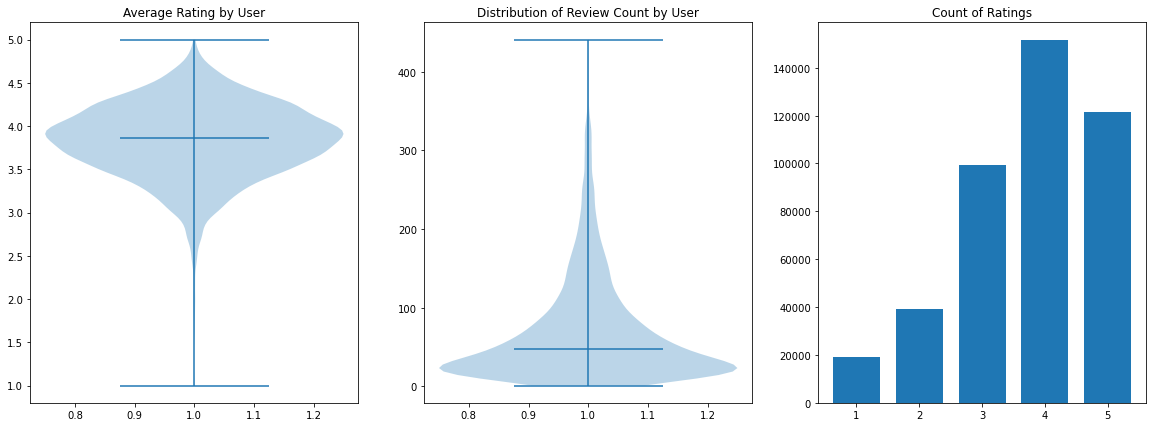

In [11]:
print("Number of reviews with a rating of 5: {}".format(len(dfAllRatings[dfAllRatings.rating == 5])))

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3)

#ax1.plot(dfAllRatings.groupby('uID')['rating'].mean())
ax1.violinplot(dfAllRatings.groupby('uID')['rating'].mean(), showmedians = True)
ax1.set_title('Average Rating by User')

ax2.violinplot(dfAllRatings.groupby('uID')['rating'].count(), showmedians = True)
ax2.set_title('Distribution of Review Count by User')

ax3.hist(dfAllRatings.rating, bins = range(1, 7), rwidth = 0.75)
ax3.set_xticks(np.arange(1.5, 6.5), labels = range(1, 6))
ax3.set_title('Count of Ratings')

fig.set_figheight(7)
fig.set_figwidth(20)
plt.show()

From the plot on the left, the mean and median average review is just under 4, the middle shows that most users that have contributed reviews have made several of them, and the last one shows a heavy skew toward the higher end of reviews. Even with this skew though there are still approximately 20,000 one star reviews to work with.

The text of reviews will likely need some cleaning. First all numbers will be replaced an "curly quotes" replaced with a straight one.

In [12]:
dfMovies.all_reviews.replace(to_replace = "’", value = "\'", inplace = True, regex = True)
dfMovies.all_reviews.replace(to_replace = "\\d+", value = "", inplace = True, regex = True)


To gain insight into the corpus of reviews, a CountVectorizer is used and then a plot made of the top 60 words.

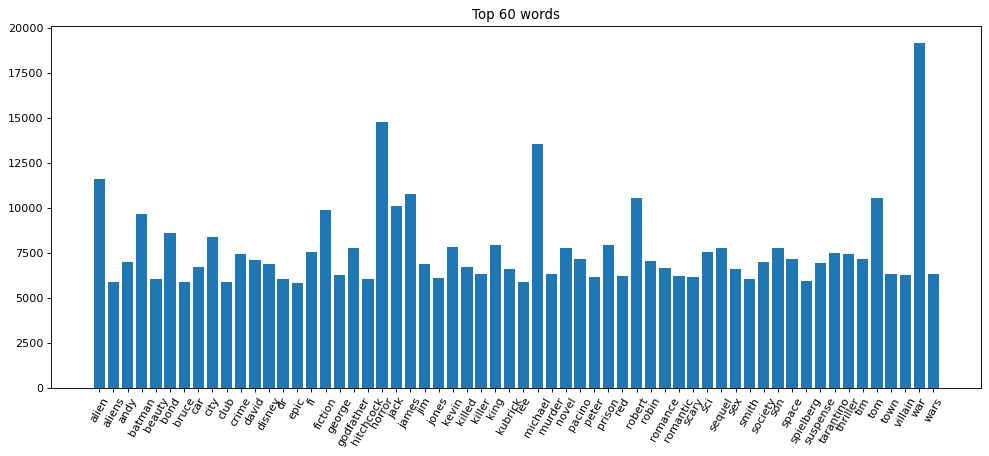

In [13]:
nTopWords = 60
tf_vectorizer = CountVectorizer(max_df = 0.80, min_df = 2, max_features = nTopWords, stop_words = "english")
tf = tf_vectorizer.fit_transform(dfMovies.all_reviews)     

figure(figsize=(15, 6), dpi=80)
plt.title("Top {} words".format(nTopWords))
plt.bar(x = tf_vectorizer.get_feature_names_out(), height = np.sum(tf.toarray(), axis=0))
plt.xticks(rotation = 60)
plt.show()


From looking at the top 60 words, some data clean-up will be required. First all text will be made lower case and all first names in the top 60 words will be removed.  Additionally, "sci" and "fi" are being treated as separate words so they'll be made into a single word without a hyphen.


In [14]:
dfMovies.all_reviews = dfMovies.all_reviews.transform(lambda review: review.lower())

for word in ("andy", "bruce", "david", "dr", "george", "jack" "james", "jim", \
             "kevin", "michael", "peter", "robert", "robin", "smith", "tim", "tom"):
    dfMovies.all_reviews.replace(to_replace = "\\b" + word + "\\b", value = "", inplace = True, regex = True)
dfMovies.all_reviews.replace(to_replace = "\\bsci.?fi\\b", value = "scifi", inplace = True, regex = True)

### Step 3:  Modeling
A Non-negative Matrix Factorization model was chosen for the unsupervised algorithm. The model was fitted using the "kullback-leibler" loss function and the "mu" solver and the input was a TfIdf fitted model of all the reviews.

The n_components value was set to 18 as that was the number of genres in the original Movies dataset, but this can be chosen to be any value.

In [15]:
def fitNMF(tfidf, n_topicLabels, alpha, lossFunc, solverArg):
    nmf = NMF(
        n_components = n_topicLabels,
        random_state = randomState,
        init = "nndsvda",
        beta_loss = lossFunc,
        solver = solverArg,
        max_iter = 1000,
        alpha_W = alpha,
        alpha_H = alpha,
        l1_ratio = 0.5,
    ).fit(tfidf)
    return nmf

nClusters = 18

tfidf_vectorizer = TfidfVectorizer(max_df = 0.80, min_df = 2, max_features = 100, stop_words = "english")

tfidfTrans = tfidf_vectorizer.fit_transform(dfMovies.all_reviews)
nmfFit = fitNMF(tfidfTrans, nClusters, 0.00005, "kullback-leibler", "mu")

nmfTrans = nmfFit.transform(tfidfTrans)


In [16]:
# A couple of helpful dictionaries for lookups
mid2idx = dict(zip(dfMovies.mID, list(range(len(dfMovies)))))
idx2Mid = dict(zip(list(range(len(dfMovies))), dfMovies.mID))


With the NMF model fitted, similarities need to be computed. A cosine similarity was used after an experiment with Jaccard returned an indentity matrix.

After similarities are computed, a quick check can be made as to how well the fitted model finds movies that are "similar" to a given movie.

The findSimilar function required tuning before taking its final form. Initially the rankings were chosen based on dividing the possible cosine similarity number space into 5 evenly spaced categories (i.e. 0.8, 0.6, 0.4, 0.2, and 0.0). However, after examing the actual cosine similarity numbers, no values under 0.5 were seen.  In hindsight this makes sense as it would be difficult for the text of any movies review to be the "opposite" of another's without doing and extensive sentiment analysis (a completely different machine learning problem).  Even if such analysis was done, once all reviews for a movie were aggragated any analysis of an individual review is worthless.  
  
Instead, the brackets were modified to work with the actual cosine similarities (i.e. .9, .8, .7, .6, and .5). Upon further reflection though, the cutoffs were chosen to match those typically used to assign letter grades. By using these cut-offs, an "A" similarity would be ranked a 5, an "A-", "B+", or B", would be ranked a 4 and so on. This seemed like a valid choice and yielded good results, but is definitely an opportunity for fine tuning.

In [66]:
def findSimilar(simMatrix, mID, cutOffs):
    mIndex = mid2idx[mID]

    movieIDs = {} 
    [movieIDs.setdefault(i, []) for i in range(1, 6)] 

    sortedSim = np.argsort(simMatrix[mIndex])
    for i in range(len(sortedSim) - 1, -1, -1):
        itemSim = simMatrix[mIndex, sortedSim[i]]
        
        if itemSim == 1:
            continue
        elif (itemSim >= cutOffs[0]):
            movieIDs[5].append(idx2Mid[sortedSim[i]])
        elif (itemSim >=  cutOffs[1]):
            movieIDs[4].append(idx2Mid[sortedSim[i]])
        elif (itemSim >=  cutOffs[2]):
            movieIDs[3].append(idx2Mid[sortedSim[i]])
        elif (itemSim >=  cutOffs[3]):
            movieIDs[2].append(idx2Mid[sortedSim[i]])
        else:
            movieIDs[1].append(idx2Mid[sortedSim[i]])
    return movieIDs

def showTopN(movieID, dictMovies, nTop = 5):
    print()
    print("Movies like: {}".format(dfMovies[dfMovies.mID == movieID].title.to_string(index=False)))
    for rank in range(5, 0, -1):
        line = "Rank {}: ".format(rank)
        for i in range(min(nTop, len(dictMovies[rank]))):
            movie = dfMovies.loc[dfMovies.mID == dictMovies[rank][i]]
            #line += str(i) + "-" + movie.mID.to_string(index=False) + ": " 
            line += movie.title.to_string(index=False) + "; "
        print(line)

def getCosineSimilarities(transData):
    dist = distance.pdist(transData, metric = 'cosine')
    dist[np.isnan(dist)] = 0
    similarity = ((1 - distance.squareform(dist)) * .5) + .5
    return similarity

cosSim = getCosineSimilarities(nmfTrans)
for mId in dfMovies.head(5).mID:
    simMovieIDs = findSimilar(cosSim, mId, [0.93, 0.83, 0.73, 0.63])
    showTopN(mId, simMovieIDs, 3)



Movies like: Toy Story
Rank 5: Bug's Life, A; Tarzan; Lion King, The; 
Rank 4: Chicken Run; Stand by Me; Rocketeer, The; 
Rank 3: James and the Giant Peach; Space Jam; Jungle2Jungle (a.k.a. Jungle 2 Jungle); 
Rank 2: Robin Hood: Men in Tights; Babe; Snow Day; 
Rank 1: Ran; Free Willy; Godzilla; 

Movies like: Jumanji
Rank 5: Good Will Hunting; Patch Adams; Mrs. Doubtfire; 
Rank 4: Amistad; Borrowers, The; Awakenings; 
Rank 3: Raiders of the Lost Ark; Beverly Hills Cop III; Drop Dead Gorgeous; 
Rank 2: Indiana Jones and the Last Crusade; Flintstones, The; Free Willy; 
Rank 1: Island of Dr. Moreau, The; Deep Blue Sea; Dial M for Murder; 

Movies like: Heat
Rank 5: Carlito's Way; Dog Day Afternoon; Scent of a Woman; 
Rank 4: Mars Attacks!; Casino; Backdraft; 
Rank 3: Meet the Parents; Awakenings; Deer Hunter, The; 
Rank 2: End of Days; Nightmare Before Christmas, The; Teenage Mutant Ninja Turtles; 
Rank 1: Judge Dredd; Elizabeth; Toy Story 2; 

Movies like: Sabrina
Rank 5: You've Got Mai

From the similarity rankings each of the 5 movies shown in the above cell, the recommendation appears to be doing it's job as it is recommending for example that "A Bug's Life", "Tarzan", and "The Lion King" are the movies most similar to "Toy Story".  

Next the actual accuracy of the recommendation system will be calculated.

In [18]:
def getAccuracy(df, simMatrix, cutOffs = [0.93, 0.83, 0.73, 0.63], minRank = 1, speed_up = True):
    actual = []
    pred = []
    like = []
    within1 = []
    
    if speed_up:
        nRecords = 4000
    else:
        nRecords = len(df)
    
    for uId in df[df.rating == 5].uID.unique()[:nRecords]:
        dfUser = df.loc[df.uID == uId]
        dictUser = dict(zip(dfUser.mID, dfUser.rating))
        for mId in dfUser.loc[dfUser.rating == 5].mID:
            simMovieIDs = findSimilar(simMatrix, mId, cutOffs)
            for rank in simMovieIDs:
                if rank < minRank:
                    continue
                for movieId in simMovieIDs[rank]:
                    if movieId in dictUser:
                        rating = dictUser[movieId]
                        actual.append(rating)
                        pred.append(rank)
                        if rating >= rank:
                            like.append(rating)
                        else:
                            like.append(rank)
                        if rank - 1 <= rating <= rank + 1:
                            within1.append(rating)
                        else:
                            within1.append(rank)

    return actual, pred, like, within1

def outputAccuracy(actual, pred, like, within1):
    print("Predictions made: {}".format(len(actual)))
    print("\t\t\tAccuracy\tRMSE")
    print("Perfect Prediction:\t{:.4f}\t\t{:.4f}".format(metrics.accuracy_score(actual, pred), metrics.mean_squared_error(actual, pred) ** .5))
    print("At Least as Good:\t{:.4f}\t\t{:.4f}".format(metrics.accuracy_score(actual, like), metrics.mean_squared_error(actual, like) ** .5))
    print("Within 1 Star:\t\t{:.4f}\t\t{:.4f}".format(metrics.accuracy_score(actual, within1), metrics.mean_squared_error(actual, within1) ** .5))


In [53]:
actual, pred, like, within1 = getAccuracy(dfAllRatings, cosSim, speed_up = False)
outputAccuracy(actual, pred, like, within1)
print("\nConfusion Matrix:")
print(metrics.confusion_matrix(actual, pred))


Predictions made: 14540943
			Accuracy	RMSE
Perfect Prediction:	0.0775		2.7599
At Least as Good:	0.9592		0.3327
Within 1 Star:		0.2260		2.7329

Confusion Matrix:
[[ 474462   72032   34561   21233   12470]
 [ 927160  137481   67805   44512   26329]
 [2374574  345022  171569  118995   70464]
 [3854137  563617  285986  209176  125222]
 [3435702  538118  279644  215836  134836]]


That is some pretty horrible accuracy!  But this is a movie **recommendation** system and it doesn't need to accuratately predict what movies someone will not want to see. This means how accurately the system predicts disimilar movies to one a user liked is not required. Instead the accuracy of only movies that the system believes will be of interest to the user will be measured by returning only those movies that it believes will rank a 4 of higher based on the similarity of the movie given to it.  
  
Note: The "At Least as Good" above is not a good measure for accuracy when using all predictions because _any_ movie will rank at least as good as 1 star.

In [20]:
actual, pred, like, within1 = getAccuracy(dfAllRatings, cosSim, minRank = 4, speed_up = False)
outputAccuracy(actual, pred, like, within1)

Predictions made: 979073
			Accuracy	RMSE
Perfect Prediction:	0.3514		1.2572
At Least as Good:	0.5718		1.1663
Within 1 Star:		0.8213		1.0539


The modification to only measure the accuracy of movies that the system beleives the someone will want to see improves the accuracy considerably increasing it to 35.14%. This comes at the expense of making fewer predictions (979,073 vs. 14,540,943).  Additionally, the system rated a movie at least a high as the recommendation system 57.18% of the time and the system was within 1 star of users actual ratings 82.13% (meaning if the system predicted a 5 then the user rated the movie a 4 or 5 and if the system predicted a 4 then the user rated the movie a 3, 4, or 5).  
  
Based solely on user submitted reviews this appears to be an interesting approach for movie recommendations. However, recall from visualizations above that there is a heavy skew toward in user rating with a score of 3 or above. As a result, a system that predicts only 4's might achieve a good accuracy figure.  
  
In order to get a better idea of how well the system performs, a count of user ratings in each category is found and then the minimum determined. Then a random sample of that minimum count is chosen from each of the user rating categories.

In [21]:
def getSubset(df, count, rank):
    return df[df.rating == rank].sample(n =  count, random_state = randomState)

lowCount = min(len(dfAllRatings[dfAllRatings.rating == 1]), len(dfAllRatings[dfAllRatings.rating == 2]), \
               len(dfAllRatings[dfAllRatings.rating == 3]), len(dfAllRatings[dfAllRatings.rating == 4]), \
               len(dfAllRatings[dfAllRatings.rating == 5]))

dfRating1 = getSubset(dfAllRatings, lowCount, 1)
dfRating2 = getSubset(dfAllRatings, lowCount, 2)
dfRating3 = getSubset(dfAllRatings, lowCount, 3)
dfRating4 = getSubset(dfAllRatings, lowCount, 4)
dfRating5 = getSubset(dfAllRatings, lowCount, 5)

dfBalancedRatings = pd.concat([dfRating1, dfRating2, dfRating3, dfRating4, dfRating5])
print(len(dfBalancedRatings))
  

96110


After balancing the user ratings so that there are the same number of each rating in the dataframe there are still 96,110 ratings (19,222 per star rating) for the system to work with. The accuracy of the recommendation system is now calculated again on this balanced data set.

In [22]:
actual, pred, like, within1 = getAccuracy(dfBalancedRatings, cosSim, minRank = 4, speed_up = False)
outputAccuracy(actual, pred, like, within1)

Predictions made: 32101
			Accuracy	RMSE
Perfect Prediction:	0.2378		1.8794
At Least as Good:	0.4062		1.8341
Within 1 Star:		0.5996		1.7806


The system's performance on the balanced dataset degrades significantly, but an accuracy where the user ranks a movie at least at high as the system of 59.96% is still interesting given that only user submitted reviews are used to create the similarities between movies.

#### Hyperparameter Tuning
There are 3 oportunities for tuning these results further, the TfidfVectorizer, the Non-Negative Matrix Factorization, and the cut offs for the findSimilar function.

When the testing programmatically for the max_df and max_features parameters the best accuracy and RMSE scores were found with a max_df of 1.0 and max_features of 189. Because of the amount of output though this step is not shown below. However, the other programatic tuning is shown below for completeness.  
  
It should be noted that although these parameters were tested serially, a better method would be to test them in parallel to detemine any interactions that might impact the final model.  However, time restrictions prevented this approach from being taken (these models take a while to fit and transform).

In [24]:
finalVectorizer = TfidfVectorizer(max_df = 1.0, min_df = 2, max_features = 189, stop_words = "english")
finalTfidfTrans = finalVectorizer.fit_transform(dfMovies.all_reviews)

Initial programmatic testing for optimal number of clusters was determined 63 and 66. The code below demonstrates how the optimal 65 was arrived at as a balance of accuracy and RMSE. 

In [25]:
clusterList = range(63, 67, 1)
for cluster in clusterList:
    print("With cluser count: {}".format(cluster))

    tuningNmf = fitNMF(finalTfidfTrans, cluster, 0.00005, "kullback-leibler", "mu")
    tuningNmfTrans = tuningNmf.transform(finalTfidfTrans)

    simMatrix = getCosineSimilarities(tuningNmfTrans)
    actual, pred, like, within1 = getAccuracy(dfBalancedRatings, simMatrix, minRank = 4, speed_up = False)
    outputAccuracy(actual, pred, like, within1)


With cluser count: 63
Predictions made: 24536
			Accuracy	RMSE
Perfect Prediction:	0.2404		1.4511
At Least as Good:	0.5896		1.3254
Within 1 Star:		0.7553		1.2613

With cluser count: 64
Predictions made: 24159
			Accuracy	RMSE
Perfect Prediction:	0.2388		1.4596
At Least as Good:	0.5860		1.3354
Within 1 Star:		0.7507		1.2722

With cluser count: 65
Predictions made: 23483
			Accuracy	RMSE
Perfect Prediction:	0.2395		1.4588
At Least as Good:	0.5845		1.3354
Within 1 Star:		0.7512		1.2714

With cluser count: 66
Predictions made: 24270
			Accuracy	RMSE
Perfect Prediction:	0.2362		1.4603
At Least as Good:	0.5836		1.3360
Within 1 Star:		0.7494		1.2725



With the number of clusters determined, beta loss and solver functions were evaluated.

In [26]:
lossList = ['frobenius', 'kullback-leibler', 'itakura-saito']
solverList = ['cd', 'mu']
for betaLoss in lossList:
    for solver in solverList:
        try:
            tuningNmf = fitNMF(finalTfidfTrans, 65, 0.00005, betaLoss, solver)
            tuningNmfTrans = tuningNmf.transform(finalTfidfTrans)
        except:
            continue

        print("Beta Loss: {}\t\tSolver: {}".format(betaLoss, solver))
        simMatrix = getCosineSimilarities(tuningNmfTrans)
        actual, pred, like, within1 = getAccuracy(dfBalancedRatings, simMatrix, minRank = 4, speed_up = False)
        outputAccuracy(actual, pred, like, within1)
        print()


Beta Loss: frobenius		Solver: cd
Predictions made: 76710
			Accuracy	RMSE
Perfect Prediction:	0.2316		1.5387
At Least as Good:	0.5347		1.4369
Within 1 Star:		0.7104		1.3744

Beta Loss: frobenius		Solver: mu
Predictions made: 33994
			Accuracy	RMSE
Perfect Prediction:	0.2356		1.4765
At Least as Good:	0.5740		1.3571
Within 1 Star:		0.7434		1.2931

Beta Loss: kullback-leibler		Solver: mu
Predictions made: 23483
			Accuracy	RMSE
Perfect Prediction:	0.2395		1.4588
At Least as Good:	0.5845		1.3354
Within 1 Star:		0.7512		1.2714



The testing for various beta loss and solver functions showed that the original choices of kullback-leibler and mu respectively gave the best results.

In [27]:
finalNmf = fitNMF(finalTfidfTrans, 65, 0.00005, "kullback-leibler", "mu")
finalNmfTrans = finalNmf.transform(finalTfidfTrans)
finalSimMatrix = getCosineSimilarities(finalNmfTrans)

Lastly, the cut off ranges for the similarities was tested and the values of .95, .85, .75, .65 showed the best _balanced_ accuracy results across the three accuracy scores as shown below.

In [28]:
cutOffList = np.arange(.60, .70, .01)
for cutOff in cutOffList:
    print("Low cut off {:.2f}".format(cutOff))
    actual, pred, like, within1 = getAccuracy(dfBalancedRatings, finalSimMatrix, \
                                              [cutOff + .3, cutOff + .2, cutOff + .1, cutOff], minRank = 4, speed_up = False)
    outputAccuracy(actual, pred, like, within1)
    print()

Low cut off 0.60
Predictions made: 47757
			Accuracy	RMSE
Perfect Prediction:	0.2383		1.5119
At Least as Good:	0.5555		1.4031
Within 1 Star:		0.7276		1.3403

Low cut off 0.61
Predictions made: 38321
			Accuracy	RMSE
Perfect Prediction:	0.2391		1.4919
At Least as Good:	0.5670		1.3777
Within 1 Star:		0.7361		1.3149

Low cut off 0.62
Predictions made: 29977
			Accuracy	RMSE
Perfect Prediction:	0.2370		1.4749
At Least as Good:	0.5772		1.3547
Within 1 Star:		0.7444		1.2915

Low cut off 0.63
Predictions made: 23483
			Accuracy	RMSE
Perfect Prediction:	0.2395		1.4588
At Least as Good:	0.5845		1.3354
Within 1 Star:		0.7512		1.2714

Low cut off 0.64
Predictions made: 18037
			Accuracy	RMSE
Perfect Prediction:	0.2419		1.4513
At Least as Good:	0.5880		1.3267
Within 1 Star:		0.7544		1.2624

Low cut off 0.65
Predictions made: 13564
			Accuracy	RMSE
Perfect Prediction:	0.2462		1.4439
At Least as Good:	0.5922		1.3186
Within 1 Star:		0.7565		1.2548

Low cut off 0.66
Predictions made: 9933
			Accuracy	

The model with the tuned hyperparameters compares favorably to the original model when working with the balanced dataset.

|                    | Org. Accuracy | Orig. RMSE | Tuned Accuracy | Tuned RMSE |
|--------------------|---------------|------------|----------------|------------|
| Perfect Prediction | 0.2378        | 1.8794     | 0.2462         | 1.4439     |
| At Least as Good   | 0.4062        | 1.8341     | 0.5922         | 1.3186     |
| Within 1 Star      | 0.5996        | 1.7806     | 0.7565         | 1.2548     |

We can all see how this model performs on the original (skewed) data instead of the balanced dataset.

In [55]:
actual, pred, like, within1 = getAccuracy(dfAllRatings, finalSimMatrix, [.95, .85, .75, .65], \
                                          minRank = 4, speed_up = False)
outputAccuracy(actual, pred, like, within1)
print()
print("\nConfusion Matrix:")
print(metrics.confusion_matrix(actual, pred))


Predictions made: 460971
			Accuracy	RMSE
Perfect Prediction:	0.3537		0.9926
At Least as Good:	0.7596		0.7612
Within 1 Star:		0.9256		0.6429


Confusion Matrix:
[[     0      0      0   8676    382]
 [     0      0      0  20886   1089]
 [     0      0      0  68157   3253]
 [     0      0      0 146981   8361]
 [     0      0      0 187122  16064]]


As expected, the model performs better on the original (skewed) data set. However an accuracy of 92.56% of prediction within 1 star of actual was much better than was expected.  
  
We can also examine the systems suggestions just as was done earlier in this report.

In [54]:
for mId in dfMovies.head(5).mID:
    simMovieIDs = findSimilar(finalSimMatrix, mId, [.95, .85, .75, .65])
    showTopN(mId, simMovieIDs, 3)


Movies like: Toy Story
Rank 5: 
Rank 4: Toy Story 2; Bug's Life, A; Prince of Egypt, The; 
Rank 3: Hercules; Nightmare Before Christmas, The; Princess Mononoke, The (Mononoke Hime); 
Rank 2: Heavenly Creatures; Mask of Zorro, The; Super Mario Bros.; 
Rank 1: White Men Can't Jump; Liar Liar; Jingle All the Way; 

Movies like: Jumanji
Rank 5: 
Rank 4: Casper; Jurassic Park; 
Rank 3: Mummy, The; Twister; Backdraft; 
Rank 2: Metropolis; From Dusk Till Dawn; Frighteners, The; 
Rank 1: Green Mile, The; Cliffhanger; Dial M for Murder; 

Movies like: Heat
Rank 5: 
Rank 4: Reservoir Dogs; Out of Sight; Pulp Fiction; 
Rank 3: Boondock Saints, The; Butch Cassidy and the Sundance Kid; Shawshank Redemption, The; 
Rank 2: Bird on a Wire; Interview with the Vampire; Natural Born Killers; 
Rank 1: Being John Malkovich; Misery; Bicentennial Man; 

Movies like: Sabrina
Rank 5: 
Rank 4: Parent Trap, The; Thomas Crown Affair, The; Miracle on 34th Street; 
Rank 3: 101 Dalmatians; Birdcage, The; William Sh

The most obvious difference is that in the final model, the tuned cut offs result in many fewer films being ranked a 5 compared to a given movie, however from the confusion matrix we can see that some still are.  
  
But compared to the earlier cell which diplayed suggestions (before tuning), some of the suggestions have also changed. For example, Bug's Life ranked above Toy Story 2 in the original model in similarity to Toy Story, but Toy Story 2 ranked higher in the tuned model.

As a final step, a _very_ brief comaprison was made to two other unsupervised algorithms. These were done without attempting to tune the hyperparameters for that specific alogorithm and holding the number of clusters constant. The NMF model compared very favorably with both the balanced data set and original (skewed) datasets (only balanced is shown below).

In [83]:
def unsupervisedCompare(transform):
    sim = getCosineSimilarities(transform)
    actual, pred, like, within1 = getAccuracy(dfBalancedRatings, sim, [.95, .85, .75, .65], \
                                          minRank = 4, speed_up = False)
    outputAccuracy(actual, pred, like, within1)
    print()
    
print("Final NMF:")
unsupervisedCompare(finalNmfTrans)  
print("Truncated SVD:")
unsupervisedCompare(TruncatedSVD(n_components = 65, algorithm = 'randomized', n_iter = 1000, \
                                 random_state = randomState).fit_transform(finalTfidfTrans))  
print("LatentDirichletAllocation:")
unsupervisedCompare(LatentDirichletAllocation(n_components = 65, max_iter = 1000, n_jobs = -1, \
                                              random_state = randomState).fit_transform(finalTfidfTrans))


Final NMF:
Predictions made: 13564
			Accuracy	RMSE
Perfect Prediction:	0.2462		1.4439
At Least as Good:	0.5922		1.3186
Within 1 Star:		0.7565		1.2548

Truncated SVD:
Predictions made: 473477
			Accuracy	RMSE
Perfect Prediction:	0.2230		1.8911
At Least as Good:	0.3727		1.8512
Within 1 Star:		0.5711		1.7968

LatentDirichletAllocation:
Predictions made: 505935
			Accuracy	RMSE
Perfect Prediction:	0.2319		2.3876
At Least as Good:	0.2319		2.3876
Within 1 Star:		0.4347		2.3448



### Step 4: Conclusions
The use of user submitted reviews to predict similarities, in this case for movies, is to the best of my knowledge not been done before. Recommender systems based on attributes, such as genre, and movie plots (see [Recommender System using Un-supervised Learning](https://www.kaggle.com/code/basu369victor/recommender-system-using-un-supervised-learning/data) have previously been explored, but not user generated reviews.

The results of doing predictions from user reviews does show promise though, with an accuracy and RMSE of 0.7565 and 1.2548 repsectively on the balanced dataset and 0.9256 and 0.6429 respectively on the original (skewed) dataset for movies. However, much more time would be needed to experiment for further improvements. This could be time well spent though as the use of user reviews could have broader applications for recommender systems in general, such as for restaurants.

But the most interesting part of this project for me was rethinking how to measure the the results of a recommender system. Typically measurements such as precise accuracy, precision, and recall are used. But in a recommender system, a "precise" measurement is not needed as much as one that is "close" (e.g. within 1 star). The additional insight was that it is not necessary to measure a recommender system on the things it would not recommend, which lead to chosen model being measured only on those movies ranked 4 or higher.